In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import dill as pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import torch
import nibabel as nb

import nctpy

from tqdm.notebook import tqdm

DATA7_PATH = "/System/Volumes/Data/data/data7"
projects_path = f"{DATA7_PATH}/network_control/projects"
sys.path.insert(1, projects_path)
import CAP_tools


NC_path = f"{DATA7_PATH}/network_control/projects/network_control"
sys.path.insert(1, NC_path)
import plot
import surface_mapping as sfm

import load

In [2]:
N_PARCELS = 400
data_types = ["rfMRI_REST1_7T_PA", "tfMRI_MOVIE_7T_DAY_1"]
data_exts = ["_hp2000_clean_nilearn", "_hp2000_clean_nilearn_ISCH"]

In [3]:
_, fMRI_parcellation, _, subject_list = load.load_constants(N_PARCELS)
tf_arrays, template_cifti = load.load_ptseries(subject_list, data_types,
                                               data_exts, fMRI_parcellation)

rfMRI_all, tfMRI_all = tf_arrays["rfMRI_all"], tf_arrays["tfMRI_all"]
ROI_labels, network_labels = load.load_labels(template_cifti)
network_labels = np.array(network_labels)

Loading ptseries:   0%|          | 0/174 [00:00<?, ?it/s]

### Sample Data

In [4]:
n_sample = 30_000

n_subjects = 50
offset_tr = 50

trs_per_subject = int(n_sample // n_subjects)

c_frames = rfMRI_all[:n_subjects, offset_tr:trs_per_subject + offset_tr].reshape(-1, rfMRI_all.shape[2])
unique_networks = sorted(set(network_labels))
n_frames = np.array([c_frames[:, network == network_labels].mean(axis=1) for network in unique_networks]).T

# nc_frames = c_frames / np.sum(c_frames ** 2, axis=1, keepdims=True)

# Cluster on data

In [5]:
MKM = CAP_tools.clustering.MultiKMeans

In [6]:
def get_k_distributions(frame_set, max_k):
    """ """
    ks = np.arange(2, max_k + 1)[::-1]
    
    l10_ks = []
    median_cf_ks = []
    cluster_frac_ks = []
    
    for k in tqdm(ks, desc="Fitting multiple kmean sets"):
        mkm = MKM(k=k, n_reps=1)
        mkm.fit(frame_set)
        
        cluster_counts = np.array([np.bincount(label_set.astype(int), minlength=k) for label_set in mkm.labels])
        cluster_fractions = cluster_counts / np.sum(cluster_counts, axis=1, keepdims=True)
        
        l10 = np.mean(cluster_counts <= 10)
        median_cf = np.median(cluster_fractions)
    
        l10_ks.append(l10)
        median_cf_ks.append(median_cf)
        cluster_frac_ks.append(cluster_fractions)
    
    l10_ks = np.array(l10_ks)
    median_cf_ks = np.array(median_cf_ks)
    
    min_frac_ks = np.array([np.min(cf_i) for cf_i in cluster_frac_ks])
    max_frac_ks = np.array([np.max(cf_i) for cf_i in cluster_frac_ks])
    return ks, l10_ks, median_cf_ks, min_frac_ks, max_frac_ks

In [9]:
def make_k_distribution_plots(frame_set, frame_se_label, ks, l10_ks, median_cf_ks, min_frac_ks, max_frac_ks):
    """ """
    print("\n")
    fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout(w_pad=3)
    a0.bar(ks, (1 - l10_ks) * ks, label="> 10 Volumes", color="C0", alpha=0.8)
    a0.bar(ks, l10_ks * ks, bottom=(1 - l10_ks) * ks, label="<= 10 Volumes\n",
            color="C3", alpha=0.5)
    a0.legend(title="Cluster Size")
    a0.set(xlabel="K", ylabel="Number of Clusters")
    a0.set_ylim(None, np.max(ks) + 0.2)
    a0.set_title("Number of Ultra-Small Clusters ( <= 10 Volumes ) by K")
    
    # a1.scatter(ks, min_frac_ks, color="C0", alpha=0.8, s=10)
    a1.plot(ks, min_frac_ks, color="C0", alpha=0.5, label="Minimum")
    a1.plot(ks, max_frac_ks, color="C1", alpha=0.5, label="Maximum")
    a1.scatter(ks, median_cf_ks, color="C2", alpha=0.8, s=10)
    a1.plot(ks, median_cf_ks, color="C2", alpha=0.8, label="Median")
    a1.plot(ks, 1 / ks, label="1/K line", color="k", linestyle="--", alpha=0.9)
    a1.axhline(10 / n_sample, label="Ultra-Small Cluster\n(<= 10 Volumes)", color="C3", alpha=0.6, linestyle="--")
    
    a1.legend(title="Distribution Metric")
    a1.set(xlabel="K", ylabel="Occupancy Fraction", title="Occupancy Fraction Metrics by K")
    # a1.set_yscale("log")
    fig.suptitle(f"HCP-7T Resting State:\n{n_subjects} Subjects with {trs_per_subject} "
                 f"volumes each\n{n_sample:,d} Volumes Total\nClustered on {frame_set.shape[1]} {frame_set_label}",
                 y=1.2, fontsize=12);
    plt.show()

Fitting multiple kmean sets:   0%|          | 0/149 [00:00<?, ?it/s]

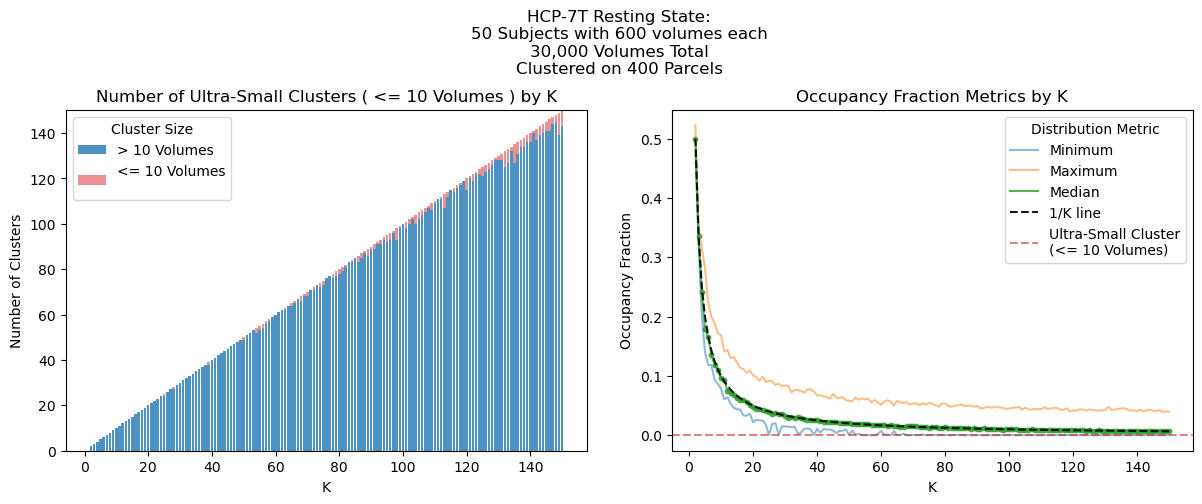

Fitting multiple kmean sets:   0%|          | 0/149 [00:00<?, ?it/s]

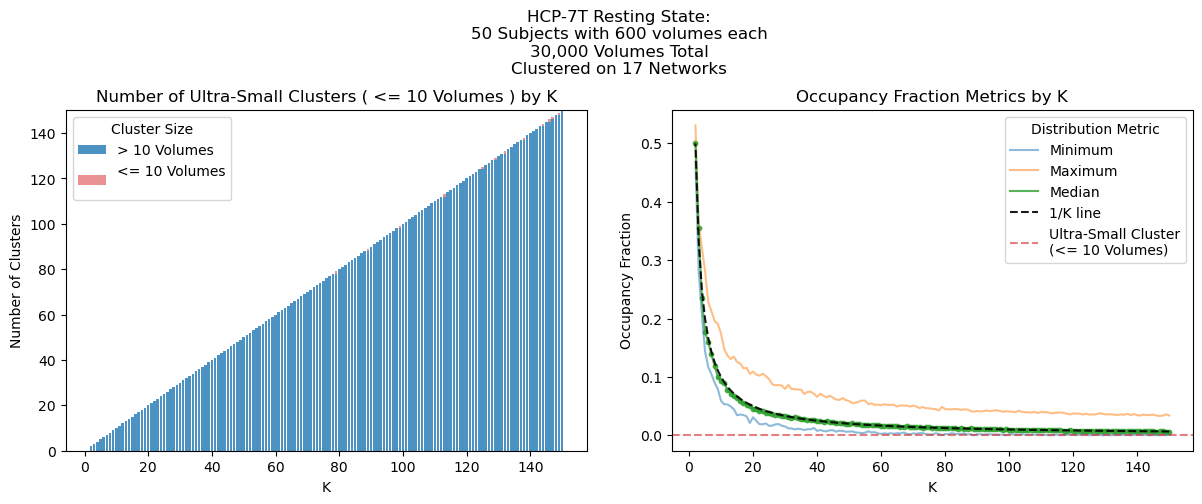

In [11]:
frame_sets = [c_frames, n_frames]
frame_set_labels = ["Parcels", "Networks"]

for frame_set, frame_set_label in zip(frame_sets, frame_set_labels):
    ks, l10_ks, median_cf_ks, min_frac_ks, max_frac_ks = get_k_distributions(frame_set, 150)
    make_k_distribution_plots(frame_set, frame_set_label, ks, l10_ks, median_cf_ks, min_frac_ks, max_frac_ks)